### README

#### Energy Drought Co-occurrence Analysis

**Overview**

This script conducts an analysis of the co-occurrence of energy droughts between different countries in Europe.

#### Instructions

**Prerequisites**
- Ensure that the required Python libraries are installed, including `numpy`, `matplotlib`, `seaborn`, `cartopy`, and custom utilities (`utils.py` and `plot_utils.py`).

**Configuration**
1. **File Paths:** Adjust the paths (`ENERGY_PATH`, `ANOM_PATH`, `PSL_PATH`) to match the location of your energy and meteorological datasets.
2. **Analysis Parameters:** Modify parameters like window size, variable type, and row ordering for plotting.
3. **Output Directories:** Update the output directories (`dir_Output`, `dir_Figures`, `dir_MeteoFigures`) to specify where the results and figures will be saved.

**Author**

Bram van Duinen

**Date (last modified)**

2024-01-22


### 1. Preliminaries

In [1]:
import utils as ut
import plot_utils as put

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
ENERGY_PATH = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
ANOM_PATH = '/net/pc230050/nobackup/users/duinen/LENTIS/present/'
PSL_PATH = '/net/pc200256/nobackup/users/most/LENTIS/present/day/psl_d/'
WINDOW = 7
VARIABLE = 'residual' # option 2: total_RE

date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
dir_Output = f'../Results/Data/{rundate}/{VARIABLE}/concurrent_probs/'
dir_Figures = f'../Results/Figures/{rundate}/{VARIABLE}/concurrent_probs/'

In [3]:
ut.check_make_dir(dir_Output)
ut.check_make_dir(dir_Figures)

data_stacked = ut.load_data(ENERGY_PATH, VARIABLE)

COUNTRY_NR = data_stacked.country.values
COUNTRY_NAME = data_stacked.country_name.values
country_nr_name = dict(zip(COUNTRY_NR, COUNTRY_NAME))
country_name_nr  = dict(zip(COUNTRY_NAME, COUNTRY_NR))

HOMEDIR = '/usr/people/duinen/MSc-thesis/'
ROW_ORDER = np.load(f'{HOMEDIR}Data/row_order_v20240116.npy') # load the row ordering of the clustered residual heatmap, to follow the same clustering!
CMAP = 'RdBu_r'

Creating dir ../Results/Data/20240125/residual/concurrent_probs/
Creating dir ../Results/Figures/20240125/residual/concurrent_probs/


### 2. Define functions

In [4]:
def calc_cooccur(c1_name, c2_name, thres, plot = False):
    """
    Calculate the probability of an energy drought event in the residual load time series of a country given the occurrence of an event in an other countries time series.

    Parameters:
        c1_name (str): Name of the first country for co-occurrence analysis.
        c2_name (str): Name of the second country for co-occurrence analysis.
        thres (float): Threshold for the first country (c1) event based on the specified quantile.
        plot (bool, optional): Whether to generate and display a 2x2 subplot showing the analyses visually. Defaults to False.

    Returns:
        float: Probability of an event in the second country (c2) given the occurrence of an event in the first country (c1).
    """
    c1 = data_stacked.sel(country = country_name_nr[c1_name])
    c2 = data_stacked.sel(country = country_name_nr[c2_name])

    thres_c1, thres_c2 = c1.quantile(thres).values, c2.quantile(0.9).values	# threshold for c2 is fixed at 90% quantile, for c1 variable

    # Compute conditions once and reuse
    cond_c1 = c1 > thres_c1
    cond_c2 = c2 > thres_c2
    cond_both = cond_c1 & cond_c2

    colors = np.where(cond_both, 'C0', 'grey')

    # Calculate the correlation coefficient for the complete residual load
    corr_all = np.corrcoef(c1, c2)[0, 1]

    # Filter the parts above the 90th percentile
    c1_both_above_thres = c1[cond_both]
    c2_both_above_thres = c2[cond_both]

    # Calculate the correlation coefficient for the parts above the 90th percentile
    corr_both_above_thres = np.corrcoef(c1_both_above_thres, c2_both_above_thres)[0, 1]

    # Filter the parts above the 90th percentile of c1
    c1_above_thres = c1[cond_c1]
    c2_above_c1thres = c2[cond_c1]

    # Calculate the correlation coefficient for the parts above the 90th percentile
    corr_above_c1thres = np.corrcoef(c1_above_thres, c2_above_c1thres)[0, 1]

    num_c1_events = len(c1_above_thres)
    num_c2_events_given_c1 = np.sum(c2_above_c1thres > thres_c2).values
    prob = num_c2_events_given_c1 / num_c1_events

    if plot == True:
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a subplot with 2 rows and 2 columns

        # First plot
        axs[0, 0].scatter(c1, c2, s = 0.1, c=colors)
        axs[0, 0].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[0, 0].axhline(y=thres_c2, color='k', linestyle='dotted')
        axs[0, 0].text(0.05, 0.95, f'r_all: {corr_all:.2f}', transform=axs[0, 0].transAxes, verticalalignment='top')
        axs[0, 0].set_xlabel(f'Residual load {c1_name} [MWh]')
        axs[0, 0].set_ylabel(f'Residual load {c2_name} [MWh]')

        # Second plot
        axs[0, 1].scatter(c1_both_above_thres, c2_both_above_thres, s = 0.1)
        axs[0, 1].axhline(y=thres_c2, color='k', linestyle='dotted')
        axs[0, 1].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[0, 1].text(0.05, 0.95, f'r_>{thres*100}: {corr_both_above_thres:.2f}', transform=axs[0, 1].transAxes, verticalalignment='top')
        axs[0, 1].set_xlabel(f'Residual load {c1_name} [MWh]')

        colors_c1 = np.where((c1 > thres_c1), 'C0', 'grey')

        # Third plot
        axs[1, 0].scatter(c1, c2, s = 0.1, c=colors_c1)
        axs[1, 0].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[1, 0].text(0.05, 0.95, f'r_all: {corr_all:.2f}', transform=axs[1, 0].transAxes, verticalalignment='top')
        axs[1, 0].set_xlabel(f'Residual load {c1_name} [MWh]')
        axs[1, 0].set_ylabel(f'Residual load {c2_name} [MWh]')

        # Create a color array for the fourth plot
        colors_c2 = np.where((c2_above_c1thres > thres_c2), 'red', 'C0')

        axs[1, 1].scatter(c1_above_thres, c2_above_c1thres, s = 0.1, c=colors_c2)
        axs[1, 1].axhline(y=thres_c2, color='k', linestyle='dotted')
        axs[1, 1].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[1, 1].text(0.05, 0.90, f'r_{c1_name}>{thres*100}: {corr_above_c1thres:.2f}', transform=axs[1, 1].transAxes, verticalalignment='top')
        axs[1, 1].text(0.05, 0.95, f"Prob. of {c2_name} event given event of {c1_name}: {prob:.2f}", transform=axs[1, 1].transAxes, verticalalignment='top')
        axs[1, 1].set_xlabel(f'Residual load {c1_name} [MWh]')
        
    return prob

In [6]:
def calc_prob(thres, threstype):
    """
    Calculate the co-occurrence probability matrix and create a DataFrame for co-occurrence analysis between different countries. The function iterates through pairs of countries, calculates the co-occurrence probability using the `calc_cooccur` function,
    and populates the probability matrix and DataFrame accordingly. The results are saved as a NumPy array and a CSV file.

    Parameters:
        thres (float): Threshold value for an energy drought event.
        threstype (str): Threshold value, used for saving the data.

    Returns:
        tuple: Tuple containing the probability matrix and DataFrame.
            - prob_matrix (numpy.ndarray): Matrix storing the probabilities of events in one country given events in another.
            - df_cooccurrence (pandas.DataFrame): DataFrame with all the co-occurrence probabilities.
    """
    prob_matrix = np.zeros((len(COUNTRY_NR), len(COUNTRY_NR)))

    columns = ['Country_1', 'Country_2', 'p_co']
    data = np.empty((len(COUNTRY_NR)**2, 3), dtype=object)

    for i, c1_name in tqdm(enumerate(COUNTRY_NAME)):
        for j, c2_name in enumerate(COUNTRY_NAME):
            prob = calc_cooccur(c1_name, c2_name, thres)
            prob_matrix[i, j] = prob
            data[i*len(COUNTRY_NAME)+j] = [c1_name, c2_name, prob]

    df_cooccurrence = pd.DataFrame(data, columns=columns)

    np.save(f'{dir_Output}{threstype}.npy', prob_matrix)
    df_cooccurrence.to_csv(f'{dir_Output}{threstype}_df.csv', index=False)
    return prob_matrix, df_cooccurrence

In [7]:
def reorder(matrix):
    """
    Reorder a matrix based on predefined row order.

    Parameters:
        matrix (numpy.ndarray): Input matrix to be reordered.

    Returns:
        numpy.ndarray: Reordered matrix based on predefined row order.
    """
    df_matrix = pd.DataFrame(matrix)

    matrix_reordered = df_matrix.reindex(ROW_ORDER, axis=0)
    matrix_reordered = matrix_reordered.reindex(ROW_ORDER, axis=1)
    return matrix_reordered.values

### 3. Perform co-occurrence analysis

In [8]:
prob_matrix09, df_09 = calc_prob(0.9, '90perc')
prob_matrix095, df_095 = calc_prob(0.95, '95perc')
prob_matrix0975, df_0975 = calc_prob(0.975, '97_5perc')
prob_matrix099, df_099 = calc_prob(0.99, '99perc')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

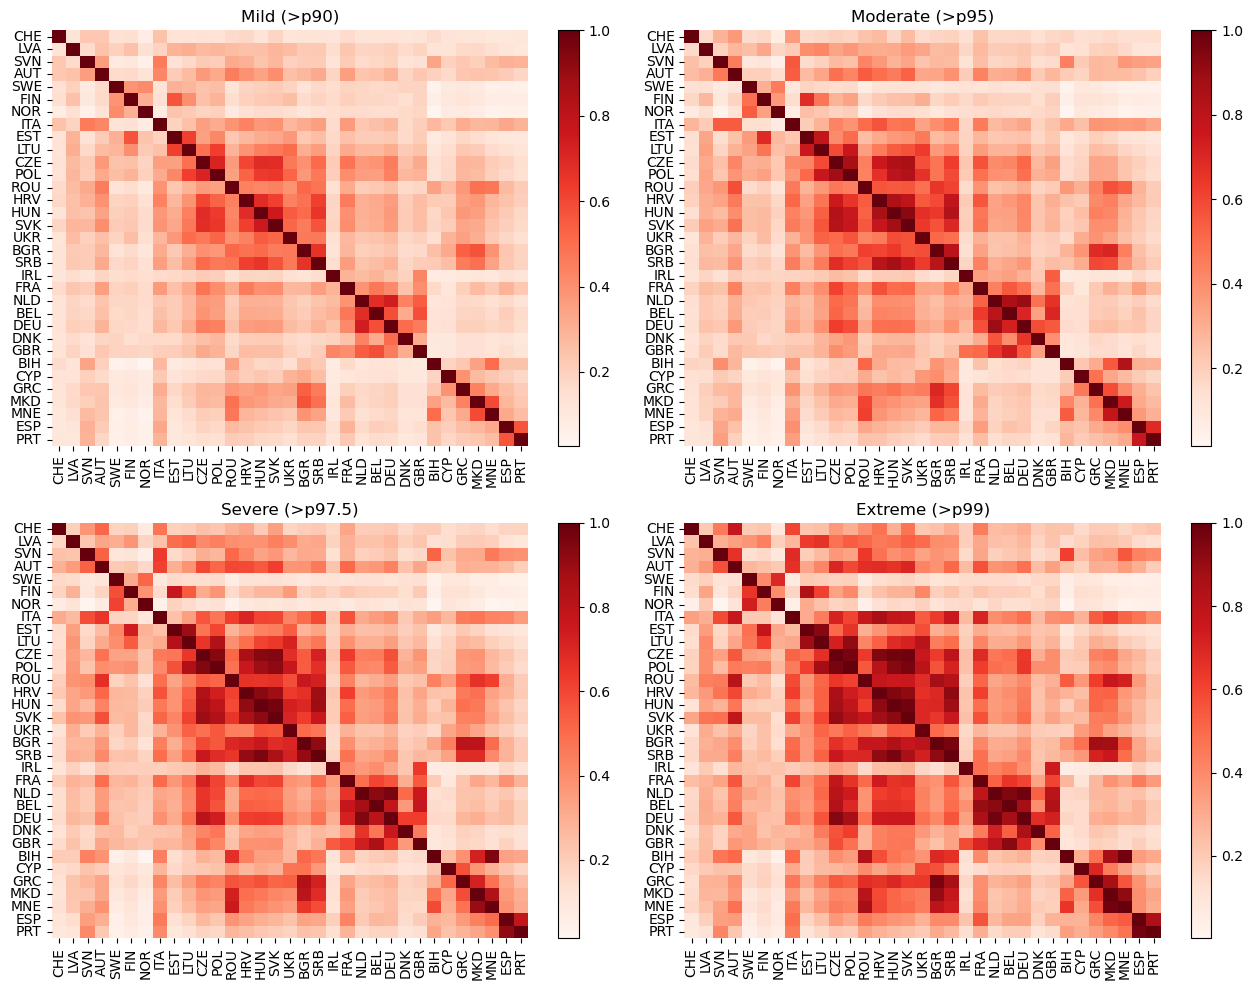

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

matrix_list = [prob_matrix09, prob_matrix095, prob_matrix0975, prob_matrix099]
type_list = ['mild', 'moderate', 'severe', 'extreme']
drought_types = ['Mild (>p90)', 'Moderate (>p95)', 'Severe (>p97.5)', 'Extreme (>p99)']

for ax, matrix, title, threstype in zip(axs.flatten(), matrix_list, drought_types, type_list):
    hm = sns.heatmap(reorder(matrix), cmap='Reds', cbar = False, xticklabels=COUNTRY_NAME[ROW_ORDER], 
                yticklabels=COUNTRY_NAME[ROW_ORDER], ax=ax)
    ax.set_title(title)
    plt.colorbar(hm.collections[0], ax=ax)

plt.tight_layout()
plt.savefig(f'{dir_Figures}heatmap_probabilities.png', dpi=300)